# Chapter 3

In [9]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import SA, MCMC, Predictive, NUTS, DiscreteHMCGibbs

import numpy as np
import jax.numpy as jnp
import jax
from jax.random import PRNGKey

import seaborn as sns

import functools

def make_random(fn):
    key = jax.random.PRNGKey(np.random.randint(0, 1e6))
    return handlers.seed(fn, rng_seed=key)

## Example: Reasoning about Tug of War

```javascript
//original webPPL code
var strength = mem(function (person) {return Math.abs(gaussian(1, 1), 0.01)})
var lazy = function(person) {return flip(1/3) }
var pulling = function(person) {
  return lazy(person) ? strength(person) / 2 : strength(person) }
var totalPulling = function (team) {return sum(map(pulling, team))}
var winner = function (team1, team2) {
  totalPulling(team1) > totalPulling(team2) ? team1 : team2 }

print([
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'tom'], ['bob', 'sue']),
    winner(['alice', 'tom'], ['bob', 'sue'])
])
```

In [81]:
## here they are as close to the webPPL as possible

@functools.lru_cache(maxsize=128)
def strength(person):
    return jnp.abs(numpyro.sample("s_{}".format(person), dist.Normal(1,1)))
    
def lazy(person):
    return numpyro.sample("l_{}".format(person), dist.Bernoulli(1/3))

def pulling(person):
    return strength(person)/2 if lazy(person)==1. else strength(person)

def totalPulling(team):
    return jnp.sum(jnp.stack([pulling(i) for i in team]))

def winner(team1, team2):
    return team1 if totalPulling(team1) > totalPulling(team2) else team2

_winner = make_random(winner)

print([
    _winner(['alice', 'bob'], ['sue', 'tom']),
    _winner(['alice', 'bob'], ['sue', 'tom']),
    _winner(['alice', 'sue'], ['bob', 'tom']),
    _winner(['alice', 'sue'], ['bob', 'tom']),
    _winner(['alice', 'tom'], ['bob', 'sue']),
    _winner(['alice', 'tom'], ['bob', 'sue'])
])

[['sue', 'tom'], ['sue', 'tom'], ['bob', 'tom'], ['bob', 'tom'], ['alice', 'tom'], ['alice', 'tom']]


In [86]:
## here we replace flow control with jax.numpy functions where possible
def model():
    @functools.lru_cache(maxsize=128)
    def strength(person):
        return jnp.abs(numpyro.sample("s_{}".format(person), dist.Normal(1,1)))
    
    def lazy(person, rnd):
        return numpyro.sample("l_{}_{}".format(person, rnd), dist.Bernoulli(1/3))
    
    def pulling(person, rnd):
        return jnp.where(lazy(person, rnd)==1, strength(person)/2., strength(person))

    def totalPulling(team, rnd):
        return jnp.sum(jnp.stack([pulling(i,rnd) for i in team]))

    def beat(team1, team2, rnd):
        # did team1 win?
        return jnp.where(totalPulling(team1, rnd) > totalPulling(team2, rnd), 1., 0.)

    beat1 = beat(['bob', 'mary'], ['tom','sue'], 1)
    beat2 = beat(['bob', 'sue'], ['tom','jim'], 2)

    numpyro.sample("beat1", dist.Bernoulli(1-jnp.exp(-15)), obs=jnp.array(beat1==1.))
    numpyro.sample("beat2", dist.Bernoulli(1-jnp.exp(-15)), obs=jnp.array(beat2==1.))
    
    
    return None


kernel = DiscreteHMCGibbs(NUTS(model, target_accept_prob=.80), modified=True)
posterior = MCMC(kernel, 500, 500, num_chains=1)

posterior.run(PRNGKey(0))


sample: 100%|██████████| 2000/2000 [00:07<00:00, 262.45it/s, 1023 steps of size 1.09e-03. acc. prob=0.78]


<AxesSubplot:ylabel='Density'>

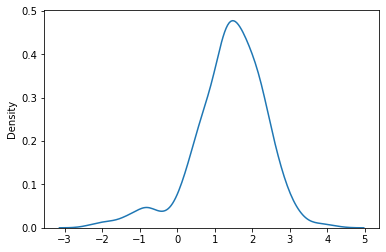

In [87]:
posterior_samples = posterior.get_samples()
sns.kdeplot(posterior_samples["s_bob"])

We can also reason about complex queries, e.g.: "how likely a team of Bob and Mary is to beat a team of Jim and Sue, given that Mary is at least as strong as sue, and Bob beat Jim in a previous direct match up"?

sample: 100%|██████████| 2000/2000 [00:06<00:00, 326.84it/s, 1023 steps of size 1.02e-03. acc. prob=0.80]


<AxesSubplot:ylabel='Count'>

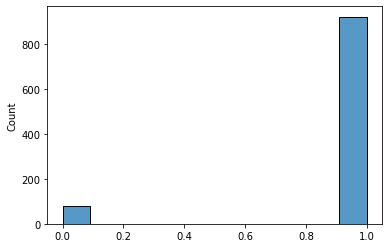

In [41]:
def model2():
    @functools.lru_cache(maxsize=128)
    def strength(person):
        return jnp.abs(numpyro.sample("s_{}".format(person), dist.Normal(1,1)))
    
    def lazy(person, rnd):
        return numpyro.sample("l_{}_{}".format(person, rnd), dist.Bernoulli(1/3))
    
    def pulling(person, rnd):
        return jnp.where(lazy(person, rnd)==1., strength(person)/2., strength(person))

    def totalPulling(team, rnd):
        return jnp.sum(jnp.stack([pulling(i, rnd) for i in team]))

    def beat(team1, team2, rnd):
        # did team1 win?
        return jnp.where(totalPulling(team1, rnd) > totalPulling(team2, rnd), 1., 0.)

    str1 = strength('mary')>=strength('sue')
    beat1 = beat(['bob'], ['jim'],1)
    
    numpyro.sample("str1", dist.Bernoulli(1-jnp.exp(-15)), obs=str1)
    numpyro.sample("beat1", dist.Bernoulli(1-jnp.exp(-15)), obs=beat1)
    
    query = beat(['bob','mary'], ['jim','sue'], 2)
    numpyro.deterministic("query", query)
    
    return None

kernel = DiscreteHMCGibbs(NUTS(model2, target_accept_prob=.80), modified=True)
posterior = MCMC(kernel, 1_000, 1_000, num_chains=1)
posterior.run(PRNGKey(0))

posterior_samples = posterior.get_samples()
posterior_predictive = Predictive(model2, posterior_samples)
sns.histplot(posterior_predictive.posterior_samples["query"])

## (note quite) Exact inference with discrete Bayesian networks

The next section of probmods is an example of causal inference in medical diagnosis using Causal bayes nets. Here's an example:

```javascript
//original webPPL code
var cancerDist = Infer({method: 'enumerate'},
  function () {
    var breastCancer = flip(0.01)
    var positiveMammogram = breastCancer ? flip(0.8) : flip(0.096)
    condition(positiveMammogram)
    return {breastCancer: breastCancer}
})
viz(cancerDist)
```
Because we're dealing with discrete causes, this is a good context for testing exact inference with discrete methods in `numpyro`. Except these features haven't been fully implemented yet. It looks like getting out the latent discrete probabilities (for exact inference on those sites) is a WIP, and possibly going to be added soon: https://github.com/pyro-ppl/numpyro/pull/977

In the webppl example they use exact inference by running the `Infer({method: "enumerate"}, ...` method. Pyro is heavily geared around approximate inference, but it can do exact inference as well, as well as enumerating out discrete factors among a larger approximate inference approach. So you can do NUTS and SVI with a few discrete factors included as well. That's a pretty cool advantage over Stan and other implementations. If what we cared about were posteriors for continuous variables from models with discete latent variables, we are all set to do that with numpyro. But since we care about the laent discretes, we need some more features to be implemented before this will work.

So in the below examples use __approximate inference__.

sample: 100%|██████████| 2000/2000 [00:03<00:00, 624.65it/s, 1 steps of size 3.40e+38. acc. prob=1.00] 


est. p(Cancer = 1|positiveMammogram) = 0.0830


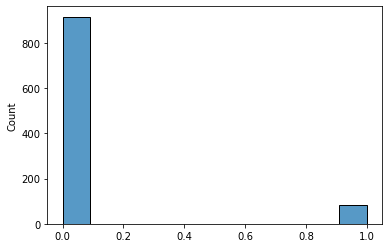

In [42]:
from numpyro.contrib.funsor.infer_util import config_enumerate
# from numpyro.contrib.funsor.discrete import infer_discrete # <--- coming soon ?

# @config_enumerate # < --- works but can't get the sample sites at this point
def model():
    breastCancer = numpyro.sample("breastCancer", dist.Bernoulli(.01))
    p_pos = jnp.where(breastCancer, .8, .096) # <--- note this is the right way to do this
    numpyro.sample("positiveMammogram", dist.Bernoulli(p_pos), obs=1.)
    return breastCancer

kernel = DiscreteHMCGibbs(NUTS(model, target_accept_prob=.80), modified=True)
posterior = MCMC(kernel, 1_000, 1_000, num_chains=1)
posterior.run(PRNGKey(0))

posterior_samples = posterior.get_samples()
posterior_predictive = Predictive(model, posterior_samples)

sns.histplot(posterior_predictive.posterior_samples["breastCancer"])
print("est. p(Cancer = 1|positiveMammogram) = {:.4f}".format(
    jnp.mean(posterior_predictive.posterior_samples["breastCancer"]))
     )

sample: 100%|██████████| 2000/2000 [00:03<00:00, 546.24it/s, 1 steps of size 3.40e+38. acc. prob=1.00] 


est. p(Cancer = 1|positiveMammogram) = 0.0950


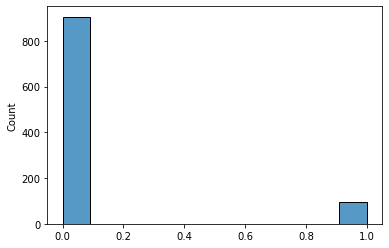

In [62]:
def noisy_or(a,b):
        return jnp.logical_or(
            jnp.logical_and(a, numpyro.sample("c1", dist.Bernoulli(.8))),
            jnp.logical_and(b, numpyro.sample("c2", dist.Bernoulli(.5)))
        )

def model():
    
    breastCancer = numpyro.sample("breastCancer", dist.Bernoulli(.01))
    benignCyst = numpyro.sample("benignCyst", dist.Bernoulli(.2))
    numpyro.sample("positiveMammogram", dist.Bernoulli(.9999), obs = noisy_or(breastCancer, benignCyst))
    
    return breastCancer

kernel = DiscreteHMCGibbs(NUTS(model, target_accept_prob=.80), modified=True)
posterior = MCMC(kernel, 1_000, 1_000, num_chains=1)
posterior.run(PRNGKey(0))

posterior_samples = posterior.get_samples()
posterior_predictive = Predictive(model, posterior_samples)

sns.histplot(posterior_predictive.posterior_samples["breastCancer"])
print("est. p(Cancer = 1|positiveMammogram) = {:.4f}".format(
    jnp.mean(posterior_predictive.posterior_samples["breastCancer"]))
     )

We can also create an empirical distribution from our MCMC samples and use that to compute the probability of different values. This is not needed here, but it is the approach we'd use to accomplish nested inference (though it won't work to put MCMC inside MCMC, so we'll need another approach).

In [79]:
import numpyro.contrib.tfp.distributions as distfp
emp_posterior = distfp.Empirical(posterior_samples["breastCancer"])
jnp.exp(emp_posterior.log_prob(1))

DeviceArray(0.09499999, dtype=float32)